In [1]:
# Pandas ile imdb verilerini manipüle etme

In [2]:
from operator import index

import pandas as pd
from matplotlib.pyplot import scatter
from pyspark.sql.functions import exists
from setuptools.command.egg_info import overwrite_arg

In [3]:
# 1. Veri setlerini yükleme
dataFrame_basics=pd.read_csv('title.basics.tsv.gz',
            compression='gzip',
            sep='\t',
            header=0,
            na_values='\\N',
            encoding='utf8',
            dtype=str
            )

In [4]:
dataFrame_ratings=pd.read_csv('title.ratings.tsv.gz',
            compression='gzip',
            sep='\t',
            header=0,
            na_values='\\N',
            encoding='utf8',
            dtype=str)

In [5]:
# 2. Sayısal alanları dönüştürme
# Not: errors="coerce" → dönüştürülemeyenler NaN olur
dataFrame_basics["startYear"]=pd.to_numeric(dataFrame_basics["startYear"],errors='coerce')

In [6]:
dataFrame_basics["runtimeMinutes"]=pd.to_numeric(dataFrame_basics["runtimeMinutes"],errors='coerce')

In [7]:
dataFrame_ratings["averageRating"]=pd.to_numeric(dataFrame_ratings["averageRating"],errors='coerce')

In [8]:
dataFrame_ratings["numVotes"]=pd.to_numeric(dataFrame_ratings["numVotes"],errors='coerce')

In [9]:
# 3. Kontrol (ilk satırları inceleyelim)
print(dataFrame_ratings.head())

      tconst  averageRating  numVotes
0  tt0000001            5.7      2180
1  tt0000002            5.5       301
2  tt0000003            6.4      2251
3  tt0000004            5.2       194
4  tt0000005            6.2      2994


In [10]:
print(dataFrame_basics.head())

      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short            Poor Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult  startYear endYear  runtimeMinutes                    genres  
0       0     1894.0     NaN             1.0         Documentary,Short  
1       0     1892.0     NaN             5.0           Animation,Short  
2       0     1892.0     NaN             5.0  Animation,Comedy,Romance  
3       0     1892.0     NaN            12.0           Animation,Short  
4       0     1893.0     NaN             1.0                     Short  


In [11]:
print(dataFrame_basics.dtypes)

tconst             object
titleType          object
primaryTitle       object
originalTitle      object
isAdult            object
startYear         float64
endYear            object
runtimeMinutes    float64
genres             object
dtype: object


In [12]:
print(dataFrame_ratings.dtypes)

tconst            object
averageRating    float64
numVotes           int64
dtype: object


In [13]:
#Sadece titleType == "movie" olan satırları seçin.
print("\nSadece film türüne ait olanlar:")
print(dataFrame_basics[dataFrame_basics["titleType"] == "movie"][["titleType", "primaryTitle", "originalTitle", "isAdult", "genres"]])


Sadece film türüne ait olanlar:
         titleType                                       primaryTitle  \
8            movie                                         Miss Jerry   
144          movie                      The Corbett-Fitzsimmons Fight   
498          movie                                           Bohemios   
570          movie                        The Story of the Kelly Gang   
587          movie                                   The Prodigal Son   
...            ...                                                ...   
11948105     movie        Rodolpho Teóphilo - O Legado de um Pioneiro   
11948129     movie  De la ilusión al desconcierto: cine colombiano...   
11948141     movie                                    Dankyavar Danka   
11948151     movie                                             6 Gunn   
11948161     movie                     Chico Albuquerque - Revelações   

                                              originalTitle isAdult  \
8                  

In [14]:
# startYear 2000–2024 aralığı dışındakileri çıkarın.
print("\n2000-2024 yılları arasındaki ürünlerin imdb listesi:")
year_mask=dataFrame_basics[(dataFrame_basics["startYear"]>2000) & (dataFrame_basics["startYear"]<2024)]
print(year_mask)


2000-2024 yılları arasındaki ürünlerin imdb listesi:
             tconst  titleType               primaryTitle  \
11630     tt0011801      movie           Tötet nicht mehr   
34793     tt0035423      movie             Kate & Leopold   
49481     tt0050396      short              Final Curtain   
51171     tt0052146      short                      Rondo   
55741     tt0056840      short                   Aufsätze   
...             ...        ...                        ...   
11948206  tt9916848  tvEpisode              Episode #3.17   
11948207  tt9916850  tvEpisode              Episode #3.19   
11948208  tt9916852  tvEpisode              Episode #3.20   
11948209  tt9916856      short                   The Wind   
11948210  tt9916880  tvEpisode  Horrid Henry Knows It All   

                      originalTitle isAdult  startYear endYear  \
11630              Tötet nicht mehr       0     2019.0     NaN   
34793                Kate & Leopold       0     2001.0     NaN   
49481          

In [58]:
import os

dizin_yolu = 'Pandas_csv'

# 'os.path.exists' kontrolünü kaldırın.
# os.makedirs(..., exist_ok=True) hem oluşturur hem de varsa hata vermez.
try:
    os.makedirs(dizin_yolu, exist_ok=True)
    print(f"'{dizin_yolu}' dizini hazır (oluşturuldu veya zaten vardı).")

    # Dosyayı kaydetme işlemi
    year_mask.to_csv(f"{dizin_yolu}/2000-24_arası_ürünler.csv",
                     mode="w",
                     header=True,
                     index=False)
    print('csv dosyası başarı ile oluşturuldu.')

except OSError as e:
    print(f"Hata: Dosya veya dizin oluşturulamadı. Detay: {e}")

'Pandas_csv' dizini hazır (oluşturuldu veya zaten vardı).
csv dosyası başarı ile oluşturuldu.


In [15]:
# runtimeMinutes için bariz aykırı/eksik değerleri ele alın (ör. negatif/0 veya mantıksız
# uzunluklar → NaN ve sonra uygun strateji).

In [16]:
print("===Başlangıç Durumu===")
print("\n Eksik veriler :\n",dataFrame_basics.isna().sum())

===Başlangıç Durumu===

 Eksik veriler :
 tconst                   0
titleType                0
primaryTitle            22
originalTitle           22
isAdult                  0
startYear          1441246
endYear           11800415
runtimeMinutes     7717502
genres              529381
dtype: int64


In [17]:
print(dataFrame_basics[dataFrame_basics["runtimeMinutes"].isna()]) # Eksik değerleri bulma

             tconst  titleType                                   primaryTitle  \
18        tt0000019      short                               The Clown Barber   
23        tt0000025      short  The Oxford and Cambridge University Boat Race   
37        tt0000039      short                              Barnet Horse Fair   
38        tt0000040      short            Barque sortant du port de Trouville   
40        tt0000042      short                     Bateau-mouche sur la Seine   
...             ...        ...                                            ...   
11948204  tt9916844  tvEpisode                                  Episode #3.15   
11948205  tt9916846  tvEpisode                                  Episode #3.18   
11948206  tt9916848  tvEpisode                                  Episode #3.17   
11948207  tt9916850  tvEpisode                                  Episode #3.19   
11948208  tt9916852  tvEpisode                                  Episode #3.20   

                           

In [18]:
#aykırı değerleri bulma
import numpy as np
min_deger=dataFrame_basics["runtimeMinutes"].min()
max_deger=dataFrame_basics["runtimeMinutes"].max()
ort=dataFrame_basics["runtimeMinutes"].mean()
medyan=dataFrame_basics["runtimeMinutes"].median()
print(min_deger)
print(max_deger)
print(ort)
print(medyan)

0.0
3692080.0
44.86391382626411
30.0


In [19]:
# %1 ve %99 persentilleri  kullanarak aykırı değer sınırlarını bulma
upper_bound=np.percentile(dataFrame_basics["runtimeMinutes"], 1)
lower_bound=np.percentile(dataFrame_basics["runtimeMinutes"],99)
print(upper_bound)
print(lower_bound)

nan
nan


 - NaN verilerin fazla bulunması nedeni ile persentiller doğru sonuç vermemektedir.İlk önce NaN veriler düzeltilerek aykırı değer bulma işlemlerini yapacağız.

In [20]:
yenilenmis_veri=dataFrame_basics["runtimeMinutes"].fillna(medyan)

In [21]:
# Yenilenmiş veri ile ortalama / medyan yeniden bulma
yeni_ort=yenilenmis_veri.mean()
yeni_medyan=yenilenmis_veri.median()
print(yeni_ort)
print(yeni_medyan)

35.263122152764126
30.0


In [22]:
# Yenilenmis veri ile persentilleri yeniden bulma
new_upper_bound=np.percentile(yenilenmis_veri,1)
new_lower_bound=np.percentile(yenilenmis_veri,99)
print(new_upper_bound)
print(new_lower_bound)

3.0
130.0


In [23]:
clipped=np.clip(yenilenmis_veri,new_lower_bound,new_upper_bound)
print(clipped)

0            3.0
1            5.0
2            5.0
3           12.0
4            3.0
            ... 
11948206    30.0
11948207    30.0
11948208    30.0
11948209    27.0
11948210    10.0
Name: runtimeMinutes, Length: 11948211, dtype: float64


# Runtime Minutes Veri Temizleme ve Aykırı Değer Analizi

## 📊 Başlangıç Durumu

**Eksik Veri Analizi:**
 - Önceliklie isna().sum() metodları ile eksik veri sayısını tespit ettik.
 - Min ve max değerler arasında aşırı fark bulunuyor
- Ortalama (44.86) ve medyan (30.0),max_değer (3692080.0) arasındaki büyük fark verinin sağa çarpık olduğunu gösteriyor
- Maksimum değerin 3.6 milyon olması bariz aykırı değerleri işaret ediyor
- İlk persentil hesaplamarında NaN verilerin çıkması veri grubunun NaN verilerden büyük ölçüde etkilediğini gösteriyor.
## 🛠️ Veri Temizleme Stratejisi
-  Yöntem olarak medyan ile doldurmayı seçtik Sebep:
-Aykırı değerlerden etkilenmez
-Veri dağılımının çarpık olması nedeniyle ortalamadan daha güvenilir
- Doldurulan veri ile persentilleri tekrardan hesapladık.Yeni aralık 3.0 dakika 130.0 dakika olarak clip aralığını bulduk.
- Ardından bu değerler arasına sabitlediğimiz veri grubu ile daha makul sürelere ulaştık.


In [24]:
# basics ve ratings veri setlerini tconst üzerinde inner join ile birleştirin.

In [25]:
inner=pd.merge(dataFrame_basics,dataFrame_ratings,on='tconst',how='inner')
print(inner)

            tconst  titleType               primaryTitle  \
0        tt0000001      short                 Carmencita   
1        tt0000002      short     Le clown et ses chiens   
2        tt0000003      short               Poor Pierrot   
3        tt0000004      short                Un bon bock   
4        tt0000005      short           Blacksmith Scene   
...            ...        ...                        ...   
1621890  tt9916846  tvEpisode              Episode #3.18   
1621891  tt9916848  tvEpisode              Episode #3.17   
1621892  tt9916850  tvEpisode              Episode #3.19   
1621893  tt9916852  tvEpisode              Episode #3.20   
1621894  tt9916880  tvEpisode  Horrid Henry Knows It All   

                     originalTitle isAdult  startYear endYear  runtimeMinutes  \
0                       Carmencita       0     1894.0     NaN             1.0   
1           Le clown et ses chiens       0     1892.0     NaN             5.0   
2                   Pauvre Pierrot  

In [59]:
inner.to_csv("Pandas_csv/inner.csv",mode="w",header=True,index=True)

Csv dosyası oluşturuldu.


In [26]:
# genres sütununu virgülle ayrılmış listeden uzatın (explode)

In [27]:
dataFrame_exploded=(inner.dropna(subset=["genres"]).assign(genres = lambda x:x["genres"].str.split(",")).explode("genres").assign(genres=lambda x:x["genres"].str.strip()))
print(dataFrame_exploded)


            tconst  titleType               primaryTitle  \
0        tt0000001      short                 Carmencita   
0        tt0000001      short                 Carmencita   
1        tt0000002      short     Le clown et ses chiens   
1        tt0000002      short     Le clown et ses chiens   
2        tt0000003      short               Poor Pierrot   
...            ...        ...                        ...   
1621892  tt9916850  tvEpisode              Episode #3.19   
1621893  tt9916852  tvEpisode              Episode #3.20   
1621894  tt9916880  tvEpisode  Horrid Henry Knows It All   
1621894  tt9916880  tvEpisode  Horrid Henry Knows It All   
1621894  tt9916880  tvEpisode  Horrid Henry Knows It All   

                     originalTitle isAdult  startYear endYear  runtimeMinutes  \
0                       Carmencita       0     1894.0     NaN             1.0   
0                       Carmencita       0     1894.0     NaN             1.0   
1           Le clown et ses chiens  

In [60]:
dataFrame_exploded.to_csv("Pandas_csv/dataFrame_exploded.csv",mode="w",header=True,index=True)

Csv dosyası oluşturuldu.


In [28]:
#  Her tür için:
#  Ortalama puan (averageRating)
#  Medyan süre (runtimeMinutes)
#  Toplam film sayısı
#  En çok oylanan ilk 3 film (başlık + yıl + puan + oy sayısı)
# Sonuçları özet bir tablo halinde verin.


In [62]:
mean_csv=dataFrame_exploded.groupby("genres")["averageRating"].mean()

In [63]:
mean_csv.to_csv("Pandas_csv/mean.csv",mode="w",header=True,index=True)

In [64]:
median_csv=dataFrame_exploded.groupby("genres")["runtimeMinutes"].median()

In [65]:
median_csv.to_csv("Pandas_csv/median.csv",mode="w",header=True,index=True)

In [66]:
count_csv=dataFrame_exploded.groupby("genres").agg({
    'tconst':'count'
})


In [67]:
count_csv.to_csv("Pandas_csv/count.csv",mode="w",header=True,index=True)

In [32]:
top_3_films=(dataFrame_exploded.groupby("genres").apply(lambda x:x.nlargest(3,'numVotes'),include_groups=False).reset_index(drop=True))
result=top_3_films[['numVotes','startYear','averageRating','titleType','primaryTitle']].to_string(index=False)
print(result)


 numVotes  startYear  averageRating    titleType                                      primaryTitle
  3080380     2008.0            9.1        movie                                   The Dark Knight
  2735798     2010.0            8.8        movie                                         Inception
  2486413     2011.0            9.2     tvSeries                                   Game of Thrones
     7224     1972.0            5.0        movie                                       Deep Throat
     4603     1992.0            6.3        movie                                            Midori
     4507     2005.0            7.0        video                                           Pirates
  2735798     2010.0            8.8        movie                                         Inception
  2486413     2011.0            9.2     tvSeries                                   Game of Thrones
  2412719     2014.0            8.7        movie                                      Interstellar
  1283365 

In [68]:
top_3_films.to_csv("Pandas_csv/top_3_films.csv",mode="w",header=True,index=True)

In [33]:
# Gürültüyü azaltmak için en az 5.000 oy alan filmlerle yeniden hesaplayın:

In [34]:
mask=dataFrame_exploded[dataFrame_exploded["numVotes"]>5000]
print(mask)

            tconst  titleType            primaryTitle  \
9        tt0000010      short     Leaving the Factory   
9        tt0000010      short     Leaving the Factory   
11       tt0000012      short  The Arrival of a Train   
11       tt0000012      short  The Arrival of a Train   
13       tt0000014      short     The Waterer Watered   
...            ...        ...                     ...   
1621732  tt9913754  tvEpisode              Psalm 46:5   
1621732  tt9913754  tvEpisode              Psalm 46:5   
1621732  tt9913754  tvEpisode              Psalm 46:5   
1621826  tt9916362      movie                   Coven   
1621826  tt9916362      movie                   Coven   

                               originalTitle isAdult  startYear endYear  \
9        La sortie de l'usine Lumière à Lyon       0     1895.0     NaN   
9        La sortie de l'usine Lumière à Lyon       0     1895.0     NaN   
11          L'arrivée d'un train à La Ciotat       0     1896.0     NaN   
11          L'a

In [92]:
mask.to_csv("Pandas_csv/min_votes_5000_or_more.csv",mode="w",header=True,index=True)

In [35]:
#En yüksek puanlı 20 film (başlık, yıl, puan, oy sayısı)
top_20_films=(dataFrame_exploded.sort_values(by=['numVotes'],ascending=False).head(20).reset_index(drop=True))
result_20_films=top_20_films[['primaryTitle','startYear','averageRating','numVotes']].to_string(index=False)
print(result_20_films)

            primaryTitle  startYear  averageRating  numVotes
The Shawshank Redemption     1994.0            9.3   3105376
         The Dark Knight     2008.0            9.1   3080380
         The Dark Knight     2008.0            9.1   3080380
         The Dark Knight     2008.0            9.1   3080380
               Inception     2010.0            8.8   2735798
               Inception     2010.0            8.8   2735798
               Inception     2010.0            8.8   2735798
              Fight Club     1999.0            8.8   2520504
              Fight Club     1999.0            8.8   2520504
              Fight Club     1999.0            8.8   2520504
         Game of Thrones     2011.0            9.2   2486413
         Game of Thrones     2011.0            9.2   2486413
         Game of Thrones     2011.0            9.2   2486413
            Forrest Gump     1994.0            8.8   2424762
            Forrest Gump     1994.0            8.8   2424762
            Interstellar

In [70]:
top_20_films.to_csv("Pandas_csv/top_20_films.csv",mode="w",header=True,index=True)

In [36]:
#Yıllara göre ortalama puan değişimi (2000–2024) ve aynı grafikte gözlem sayısı.
# 1.Adım: Verileri özet tablo haline getirme
yearly_avg_rating=dataFrame_exploded.groupby("startYear")["averageRating"].mean().reset_index()
sorted_avg_rating=yearly_avg_rating.sort_values(by=['averageRating'],ascending=False)
print(sorted_avg_rating)

     startYear  averageRating
144     2025.0       7.379308
143     2024.0       7.283980
142     2023.0       7.238305
141     2022.0       7.181310
136     2017.0       7.149656
..         ...            ...
10      1891.0       4.369231
14      1895.0       4.331343
15      1896.0       4.072796
17      1898.0       3.918557
16      1897.0       3.361044

[146 rows x 2 columns]


In [37]:
# 2.Adım: Aralığa sabitleme
sorted_avg_rating=sorted_avg_rating[sorted_avg_rating['startYear'].between(2000,2024) ]
print(sorted_avg_rating)

     startYear  averageRating
143     2024.0       7.283980
142     2023.0       7.238305
141     2022.0       7.181310
136     2017.0       7.149656
131     2012.0       7.131724
138     2019.0       7.131500
137     2018.0       7.127981
135     2016.0       7.124606
133     2014.0       7.113198
140     2021.0       7.106646
139     2020.0       7.095606
130     2011.0       7.092348
134     2015.0       7.084121
132     2013.0       7.075718
129     2010.0       7.038124
128     2009.0       7.007549
124     2005.0       6.980401
126     2007.0       6.948848
125     2006.0       6.940561
123     2004.0       6.936516
120     2001.0       6.926211
127     2008.0       6.908688
119     2000.0       6.902510
122     2003.0       6.895879
121     2002.0       6.893284


In [38]:
# 3.Adım: Yıllık % değişimini bulma
sorted_avg_rating['rating_change_pct']=sorted_avg_rating['averageRating'].pct_change()*100
sorted_avg_rating['rating_change_abs']=sorted_avg_rating['averageRating'].diff()
print(sorted_avg_rating)

     startYear  averageRating  rating_change_pct  rating_change_abs
143     2024.0       7.283980                NaN                NaN
142     2023.0       7.238305          -0.627069          -0.045676
141     2022.0       7.181310          -0.787408          -0.056995
136     2017.0       7.149656          -0.440781          -0.031654
131     2012.0       7.131724          -0.250813          -0.017932
138     2019.0       7.131500          -0.003142          -0.000224
137     2018.0       7.127981          -0.049333          -0.003518
135     2016.0       7.124606          -0.047359          -0.003376
133     2014.0       7.113198          -0.160123          -0.011408
140     2021.0       7.106646          -0.092098          -0.006551
139     2020.0       7.095606          -0.155352          -0.011040
130     2011.0       7.092348          -0.045924          -0.003259
134     2015.0       7.084121          -0.115990          -0.008226
132     2013.0       7.075718          -0.118623

In [71]:
sorted_avg_rating.to_csv("Pandas_csv/sorted_avg_rating.csv",mode="w",header=True,index=True)

In [39]:
# 4.Adım : Grafik ile ifade etme
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
sns.set_style('whitegrid')
plt.figure(figsize=(14,10))

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

Text(0, 0.5, 'Ortlama Puan')

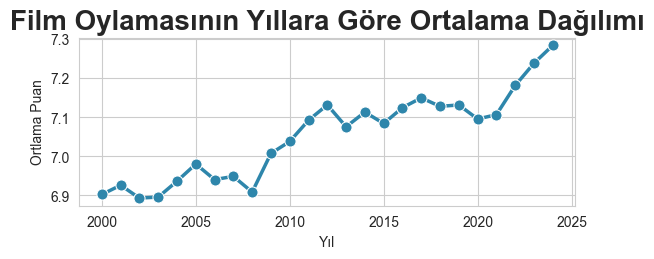

In [41]:
# 1.Grafik
plt.subplot(2,1,1)
sns.lineplot(data=sorted_avg_rating,x='startYear',y='averageRating',marker='o',linewidth=2.5,markersize=8,color='#2E86AB')
plt.title('Film Oylamasının Yıllara Göre Ortalama Dağılımı',fontsize=20,fontweight='bold')
plt.xlabel('Yıl')
plt.ylabel('Ortlama Puan')

C:\Users\mehme\AppData\Local\Temp\ipykernel_20524\859651017.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_avg_rating, x='startYear',y='rating_change_pct',palette=colors)


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, '2000.0'),
  Text(1, 0, '2001.0'),
  Text(2, 0, '2002.0'),
  Text(3, 0, '2003.0'),
  Text(4, 0, '2004.0'),
  Text(5, 0, '2005.0'),
  Text(6, 0, '2006.0'),
  Text(7, 0, '2007.0'),
  Text(8, 0, '2008.0'),
  Text(9, 0, '2009.0'),
  Text(10, 0, '2010.0'),
  Text(11, 0, '2011.0'),
  Text(12, 0, '2012.0'),
  Text(13, 0, '2013.0'),
  Text(14, 0, '2014.0'),
  Text(15, 0, '2015.0'),
  Text(16, 0, '2016.0'),
  Text(17, 0, '2017.0'),
  Text(18, 0, '2018.0'),
  Text(19, 0, '2019.0'),
  Text(20, 0, '2020.0'),
  Text(21, 0, '2021.0'),
  Text(22, 0, '2022.0'),
  Text(23, 0, '2023.0'),
  Text(24, 0, '2024.0')])

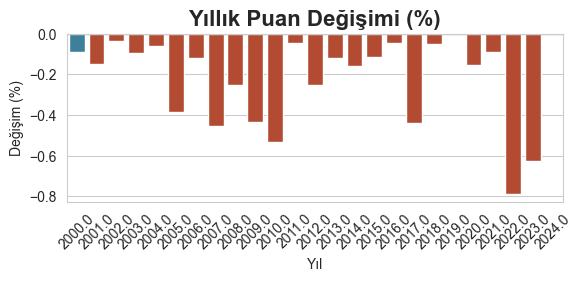

In [42]:
# 2.Grafik
plt.subplot(2,1,2)
colors=['#C73E1D' if x<0 else '#F18F01' if x<1 else '#2E86AB' for x in sorted_avg_rating['rating_change_pct']]
sns.barplot(data=sorted_avg_rating, x='startYear',y='rating_change_pct',palette=colors)
plt.axhline(y=0,color='black',linestyle='-')
plt.title('Yıllık Puan Değişimi (%)',fontsize=16,fontweight='bold')
plt.xlabel('Yıl')
plt.ylabel('Değişim (%)')
plt.xticks(rotation=45)


In [72]:
sorted_avg_rating_pd=pd.read_csv('Pandas_csv/sorted_avg_rating.csv')
print(sorted_avg_rating_pd)

    Unnamed: 0  startYear  averageRating  rating_change_pct  rating_change_abs
0          143     2024.0       7.283980                NaN                NaN
1          142     2023.0       7.238305          -0.627069          -0.045676
2          141     2022.0       7.181310          -0.787408          -0.056995
3          136     2017.0       7.149656          -0.440781          -0.031654
4          131     2012.0       7.131724          -0.250813          -0.017932
5          138     2019.0       7.131500          -0.003142          -0.000224
6          137     2018.0       7.127981          -0.049333          -0.003518
7          135     2016.0       7.124606          -0.047359          -0.003376
8          133     2014.0       7.113198          -0.160123          -0.011408
9          140     2021.0       7.106646          -0.092098          -0.006551
10         139     2020.0       7.095606          -0.155352          -0.011040
11         130     2011.0       7.092348          -0

In [73]:
sorted_avg_rating_pd=sorted_avg_rating_pd.groupby('startYear').agg(averageRating=('averageRating','mean'),movie_count=('startYear','count')).reset_index()

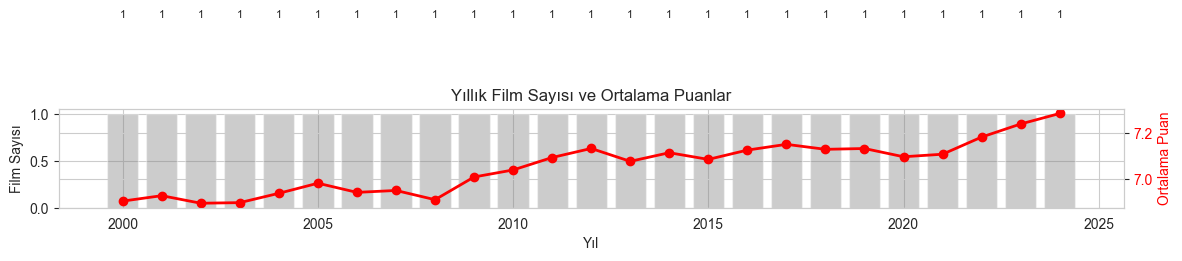

In [75]:
fig,ax=plt.subplots(figsize=(12,6))
# Gözlem Sayıları
bars=ax.bar(sorted_avg_rating_pd['startYear'],sorted_avg_rating_pd['movie_count'],alpha=0.4,color='gray',label='Film Sayısı', width=0.8)

# Ortalama Puanlar
ax2=ax.twinx()
line=ax2.plot(sorted_avg_rating_pd['startYear'],sorted_avg_rating_pd['averageRating'], 'ro-',linewidth=2,markersize=6,label='Ortalama Puan')
ax.set_xlabel('Yıl')
ax.set_ylabel('Film Sayısı')
ax2.set_ylabel('Ortalama Puan', color='red')
ax2.tick_params(axis='y',labelcolor='red')

for bar in bars:
    height=bar.get_height()
    ax.text(bar.get_x()+bar.get_width()/2.,height+1,
            f'{int(height)}',ha='center',va='bottom',fontsize=8)

plt.title('Yıllık Film Sayısı ve Ortalama Puanlar')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#Süre ile puan arasında ilişki var mı?

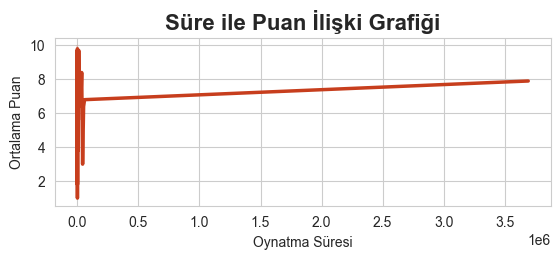

In [95]:
plt.subplot(2,1,1)
sns.lineplot(data=inner,x='runtimeMinutes',y='averageRating',markers='o',linewidth=2.5,markersize=8,color='#C73E1D')
plt.title('Süre ile Puan İlişki Grafiği',fontsize=16,fontweight='bold')
plt.xlabel('Oynatma Süresi')
plt.ylabel('Ortalama Puan')
plt.show()

## Süre/Puan İlişkisi
- Yukarıdaki grafiği incelediğimizde aykırı,NaN verileri hesaba katmadığımız durumda lineer(doğrusal) bir ilişki görmekteyiz.Bu durum da izleyici/eleştirmen puanı ile film süresi arasında güçlü bir korelasyon olduğunu gösterir,yani -bu veri grubunun verdiği sonuca dayanarak- film sektöründe uzun soluklu filmlerin izleyiciyi/eleştirmeni daha fazla etkileyerek daha yüksek puan almasını sağlıyor.Detaylandırırsak uzun soluklu filmlerin hem karmaşık ve merak uyandırıcı olay orgüsüne izleyici/eleştirmeni kaptırarak film puanlarını pozitif etkilediğini varsayabiliriz.
- Ancak aykırı verilerin dağılımı ise bu yöntemin kesin bir sonuç/garanti vermediğine de değinmeliyiz.Bu veri grubunu inceleyen bir film yapımcısının -şirket de olabilir- kesinlikle olumlu bir sonuca ulaşabileceğini söyleyemeyiz.

 - runtimeMinutes ile averageRating için korelasyon katsayısı ve dağılım grafiği
oluşturun.(Aykırı dağerler dahil)
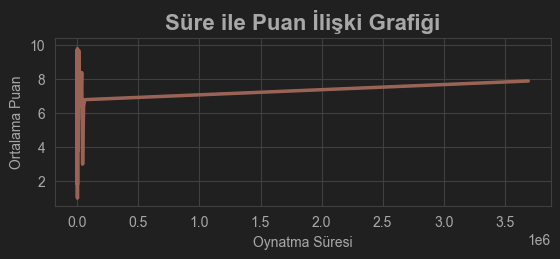

In [79]:
inner_clean=inner[['averageRating','runtimeMinutes']].dropna() # Sadece iki sütunu alıp NaN değerleri düşürelim.

In [80]:
 #Korelasyon Katsayısını Hesaplama
# Pandas, varsayılan olarak Pearson korelasyonunu kullanır.
corr_number=inner_clean['runtimeMinutes'].corr(inner_clean['averageRating'])
print(corr_number)

-0.001585569691017434


In [81]:
# Veya alternatif olarak, tüm DataFrame'in korelasyon matrisini hesaplayabilirsiniz:
# korelasyon_matrisi = df_clean.corr()
# katsayi = korelasyon_matrisi.loc[SURE_SUTUNU, PUAN_SUTUNU]
corr_matrix=inner_clean.corr()
corr_number=corr_matrix.loc['averageRating','runtimeMinutes']
print(corr_number)

-0.001585569691017287


 - Korelasyon katsayısını hesaplarken matris ve pearson yöntemini kullandık ve ikisi de birbirine çok yakın sonuçlar verdi.Bu da yöntemlerin her zaman birbirleri ile aynı sonucu vermediğini ortaya çıkardı.

In [83]:
# Dağılım Grafiği
plt.figure(figsize=(8,8))
sns.jointplot(x=inner_clean['runtimeMinutes'],y=inner_clean['averageRating'],kind='reg',height=7,scatter_kws={'alpha':0.6},line_kws={'color':'red'})
plt.suptitle('Ortalama Puan/Oynatma Süresi Korelasyon Dağılım Grafiği')
plt.xlabel('Oynatma Süresi')
plt.ylabel('Ortalama Puan')
plt.savefig('sure_puan_dagilim_grafigi.png')
plt.close()

<Figure size 800x800 with 0 Axes>

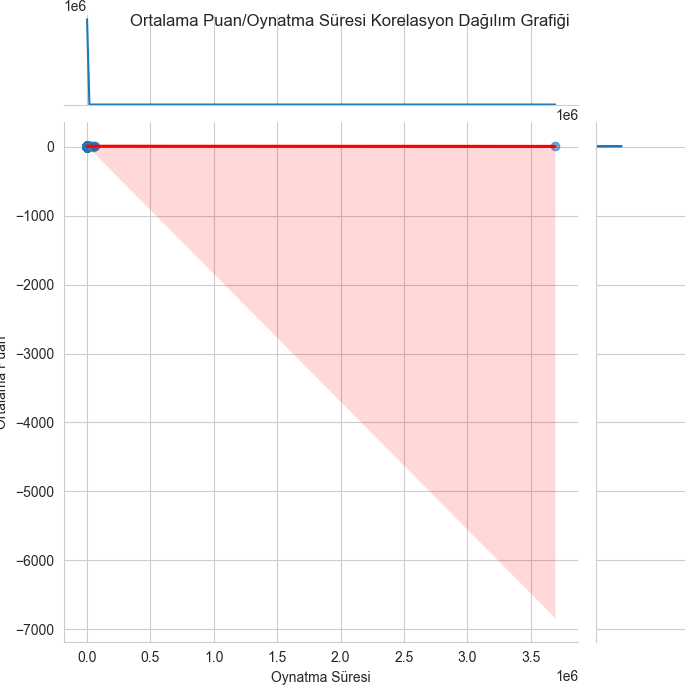

 - runtimeMinutes ile averageRating için korelasyon katsayısı ve dağılım grafiği
oluşturun.(Aykırı dağerler dahil değil )

In [85]:
# Aykırı değerlerin winsorize ile kırpılması
from scipy.stats.mstats import winsorize
inner_clean['runtimeMinutes_winsorized']=winsorize(inner_clean['runtimeMinutes'],limits=(0.05,0.05)) # %5 lik alt üst dilimin kırpılması

In [89]:
print("\n---İSTATİSTİKLERİN KARŞILAŞTIRILMASI---\n")
print(f"\nWinsorize uygulanmamış istatistikler:\n",inner_clean['runtimeMinutes'].describe())
print(f"\nWinsorize uygulanmış istatistikler:\n",inner_clean['runtimeMinutes_winsorized'].describe())


---İSTATİSTİKLERİN KARŞILAŞTIRILMASI---


Winsorize uygulanmamış istatistikler:
 count    1.143195e+06
mean     5.816118e+01
std      3.454756e+03
min      0.000000e+00
25%      2.300000e+01
50%      4.500000e+01
75%      8.400000e+01
max      3.692080e+06
Name: runtimeMinutes, dtype: float64

Winsorize uygulanmış istatistikler:
 count    1.143195e+06
mean     5.275780e+01
std      3.400043e+01
min      7.000000e+00
25%      2.300000e+01
50%      4.500000e+01
75%      8.400000e+01
max      1.200000e+02
Name: runtimeMinutes_winsorized, dtype: float64


C:\Users\mehme\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:4859: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [90]:
print(f"\nOrijinal ve Winsorize Edilmiş Uç Değerler (İlk 10 Satır):\n")
print(f"Winsorize edilmemiş kolon:",inner_clean['runtimeMinutes'].head(10))
print(f"Winsorize edilmiş kolon:",inner_clean['runtimeMinutes_winsorized'].head(10))


Orijinal ve Winsorize Edilmiş Uç Değerler (İlk 10 Satır):
Winsorize edilmemiş kolon: 0     1.0
1     5.0
2     5.0
3    12.0
4     1.0
5     1.0
6     1.0
7     1.0
8    45.0
9     1.0
Name: runtimeMinutes, dtype: float64
Winsorize edilmiş kolon: 0     7.0
1     7.0
2     7.0
3    12.0
4     7.0
5     7.0
6     7.0
7     7.0
8    45.0
9     7.0
Name: runtimeMinutes_winsorized, dtype: float64


In [91]:
#Dağılım Grafiği
plt.figure(figsize=(8,8))
sns.jointplot(x=inner_clean['runtimeMinutes_winsorized'],y=inner_clean['averageRating'],kind='reg',height=7,scatter_kws={'alpha':0.6},line_kws={'color':'red'})
plt.suptitle('Ortalama Puan/Oynatma Süresi Korelasyon Dağılım Grafiği(Aykırı değerler winsorize edilmiş haliyle)')
plt.xlabel('Oynatma Süresi')
plt.ylabel('Ortalama Puan')
plt.savefig('sure_puan_dagilim_grafigi_winsorize.png')
plt.close()


<Figure size 800x800 with 0 Axes>

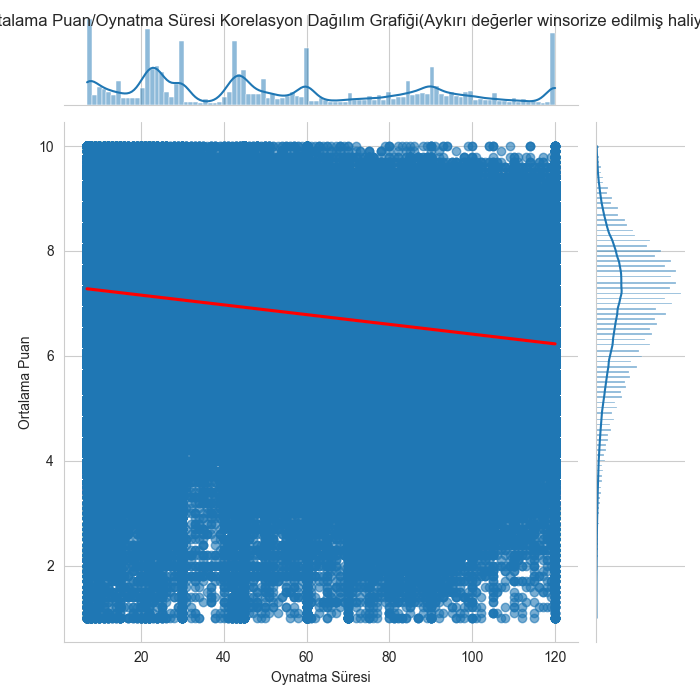
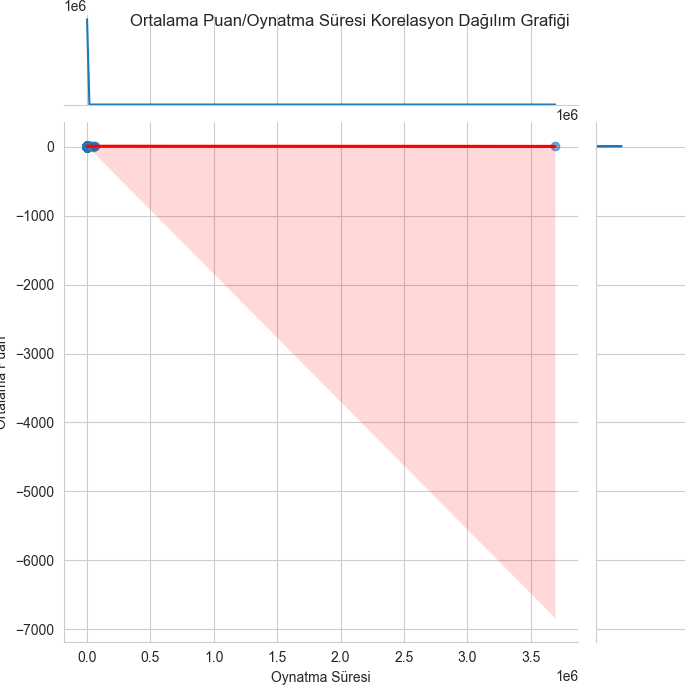

## Analiz
Bu iki grafiği incelediğimizde aykırı değerlerin veri grubunun daha net bir sonuç vermesinin önüne geçtiğini görüyoruz.Winsorize ile aykırı değerlerin kırpılması bize daha net ve temiz bir sonuç vermektedir.

# Trendler ve İçgörüler

### 📊  Analiz ve Yorumlar

- Elimizdeki verileri incelediğimizde özellikle 5000 puan ve üzeri kategorisinde tv dizilerinin ve filmlerin daha çok yer alıyor.Bu da gösteriyor ki tv dizilerinin ve filmlerin diğer kategorilere göre izleyiciyi/eleştirmeni olumlu yönde etkiliyor.

- Her bir tür sınıfında değerlendirme yapıldığında (korku,aksiyon,bilim-kurgu.vb) filmlerin daha ön plana çıktığını gözlemliyoruz.Bu da film gibi tek tüketimlik medya ürünlerinin daha çok ilgi çektiğini gösteriyor.

- Ortalama reytinglerin (2000-2024 yılları arası) doğrusal bir artışa sahip olamsı kullanıcıların medya ürünlerine olan ilgisini her geçen sene daha fazla olduğunu gösteriyorum.Buna dünya nüfusnun her geçen sene artması da dahil edilirse bu tablodaki artışın sadece bir yönelim değil ,doğal faktörlerle etkilendiğini göz önüne alabiliriz.

- Film oylamasının yıllara göre ortalama dağılımına bakarsak genel skalada bir artışı görüyoruz.Ama daha ayrıntılı incelersek belli aralıklarda düşüşleri görebiliyoruz.Bunu yüksek reytingli dizi ve filmlerin çıktığı yıllara göre yorumlarsak bu dizi ve filmlerin bu reytinglere ulaşması kısa bir sürede değil uzun vadede olduğu ortaya çıkar.

- Film sayısı ortalama reyting sayısının yıllara göre değişimi (2000/24 yılları arası) bize gösteriyor ki;bu iki değişken arasında pozitif bir korelasyon oldugunu anlatıyor.

- Özetle içeriği izleyici/eleştirmeni etkileyen medya ürünlerin daha fazla talebi olduğu ve bunun her geçen yıl artarak ilerlediğini varsayarsak bir medya yapımcısın hikayesi olan uzun soluklu içeriklere yönelmesi daha tutarlı olur.